### Import Libraries

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

# nltk.download('punkt')                       #Uncomment if not downloaded already
# nltk.download('averaged_perceptron_tagger')  #Uncomment if not downloaded already
# nltk.download('wordnet')                     #Uncomment if not downloaded already

#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix,precision_score,recall_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#for word embedding
import gensim
from gensim.models import Word2Vec #Word2Vec is mostly used for huge datasets

#For wordcloud
from wordcloud import WordCloud
%matplotlib inline

### Load Data & Analyse

In [2]:
low_memory=False
df_train=pd.read_csv('complaints_sub.csv')
print(df_train.shape)


(57173, 18)


C:\Users\AKU493\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
df_train.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,20-09-2022,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Credit inquiries on your report that you don't...,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,CA,92256.0,NaN,Consent not provided,Web,20-09-2022,Closed with explanation,Yes,NaN,6000422
1,20-09-2022,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,Experian Information Solutions Inc.,TX,78660.0,NaN,NaN,Web,20-09-2022,In progress,Yes,NaN,5998312
2,19-09-2022,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,Experian Information Solutions Inc.,NY,11731.0,NaN,NaN,Web,19-09-2022,In progress,Yes,NaN,5996790
3,19-09-2022,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account information incorrect,NaN,NaN,Experian Information Solutions Inc.,TX,78640.0,NaN,NaN,Web,19-09-2022,In progress,Yes,NaN,5996115
4,20-09-2022,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,NaN,Experian Information Solutions Inc.,TX,77084.0,NaN,NaN,Web,20-09-2022,In progress,Yes,NaN,5997667


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57173 entries, 0 to 57172
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Date received                 57173 non-null  object
 1   Product                       57173 non-null  object
 2   Sub-product                   56713 non-null  object
 3   Issue                         57173 non-null  object
 4   Sub-issue                     52761 non-null  object
 5   Consumer complaint narrative  16003 non-null  object
 6   Company public response       23432 non-null  object
 7   Company                       57173 non-null  object
 8   State                         57034 non-null  object
 9   ZIP code                      57011 non-null  object
 10  Tags                          5485 non-null   object
 11  Consumer consent provided?    32016 non-null  object
 12  Submitted via                 57173 non-null  object
 13  Date sent to com

In [5]:
len(df_train)

57173

In [6]:
#Number of Null rows for column 'Consumer complaint narrative'
df_train["Consumer complaint narrative"].isnull().sum()

41170

### Column 'Consumer complaint narrative' with data

In [7]:
len(df_train)-df_train["Consumer complaint narrative"].isnull().sum()

16003

### Selecting Required Features for further processing

In [8]:
df_train=df_train[['Product','Consumer complaint narrative']]

In [9]:
df_train=df_train.rename(columns={'Product':'product','Consumer complaint narrative':'complaint_narrative'})

In [10]:
#Selecting complaint_narrative columns where Data is Not Null
df_train=df_train[df_train["complaint_narrative"].notnull()]

In [11]:
print(len(df_train))
#df_train=df_train[0:2000]

16003


In [12]:
df_train.head()

,product,complaint_narrative
36,"Credit reporting, credit repair services, or o...",This is the second time I am filing a dispute ...
147,"Credit reporting, credit repair services, or o...","XX/XX/XXXX, & XXXX, XX/XX/XXXX, and XXXX lette..."
155,"Credit reporting, credit repair services, or o...",This is my NUMEROUS request that I have been a...
258,"Credit reporting, credit repair services, or o...",in accordance with the Fair Credit Reporting a...
324,"Credit reporting, credit repair services, or o...",Hi I am submitting this XXXX XXXX this isn't a...


In [13]:
mylabels=df_train['product'].unique()

In [14]:
products_vals=df_train['product'].value_counts()


In [15]:
df_product=pd.DataFrame(products_vals)

In [16]:
df_product = df_product.reset_index(level=0)

In [17]:
df_product.rename(columns={'index':'product_name','product':'count'},inplace=True)

In [18]:
df_product

,product_name,count
0,"Credit reporting, credit repair services, or o...",10034
1,Debt collection,1650
2,Credit card or prepaid card,1145
3,Checking or savings account,980
4,Mortgage,899
5,"Money transfer, virtual currency, or money ser...",402
6,Student loan,236
7,Vehicle loan or lease,221
8,"Payday loan, title loan, or personal loan",146
9,Credit reporting,92


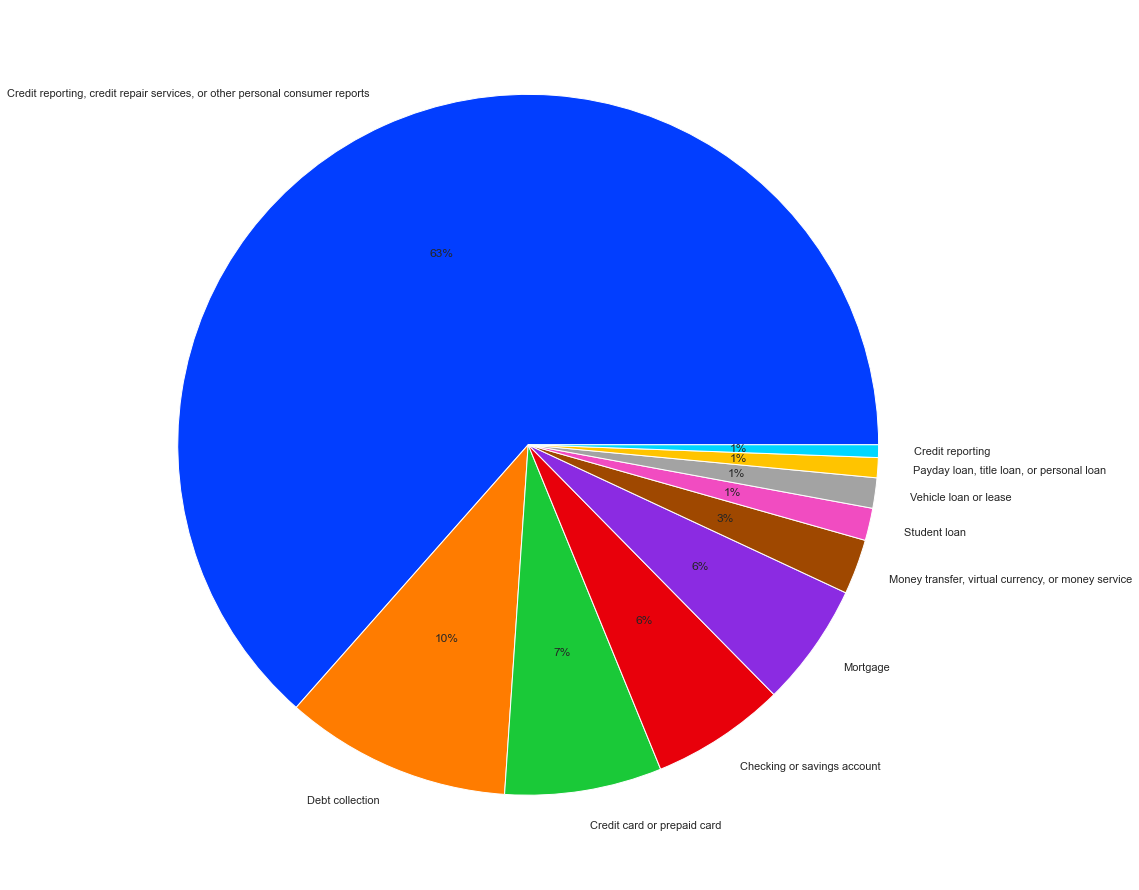

In [19]:
# importing libraries
import matplotlib.pyplot as plt
import seaborn

sns.set(rc={'figure.figsize':(15.7,19.27)})
  
# define Seaborn color palette to use
palette_color = seaborn.color_palette('bright')
  
# plotting data on chart
plt.pie(df_product['count'][0:10], labels=df_product['product_name'][0:10], colors=palette_color, autopct='%.0f%%')
  
# displaying chart
plt.show()

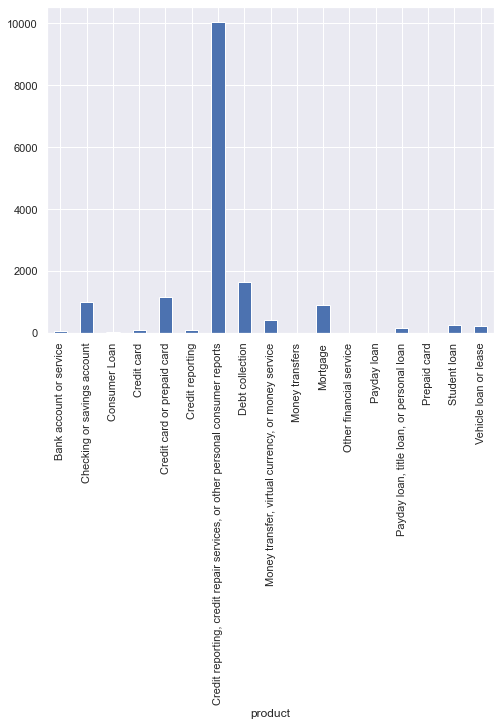

In [20]:
fig = plt.figure(figsize=(8,6))
df_train.groupby('product').complaint_narrative.count().plot.bar(ylim=0)
plt.show()

### Preprocessing

In [21]:
#1. Common text preprocessing
text = "   This is a message to be cleaned. XXXX It may involve some things like: <br>, ?, :, ''  adjacent spaces and tabs     .  "

#convert to lowercase and remove punctuations and characters and then strip
def preprocess_complains(text):
    text = text.lower() #lowercase text
    text = text.strip()  #get rid of leading/trailing whitespace 
    text = re.sub("(xx+)", '', text)
    text = re.compile('<.*?>').sub('', text) #Remove HTML tags/markups
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  #Replace punctuation with space. Careful since punctuation can sometime be useful
    text = re.sub('\s+', ' ', text)  #Remove extra space and tabs
    text = re.sub(r'\[[0-9]*\]',' ',text) #[0-9] matches any digit (0 to 10000...)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) #matches any digit from 0 to 100000..., \D matches non-digits
    text = re.sub(r'\s+',' ',text) #\s matches any whitespace, \s+ matches multiple whitespace, \S matches non-whitespace 
    
    return text

text=preprocess_complains(text)
print(text)  #text is a string

this is a message to be cleaned it may involve some things like adjacent spaces and tabs


### Removing Stop Words,POS Tagging & Lemmatization
#POS Tagging in NLTK is a process to mark up the words in text format for a particular part of a speech based on its definition and context.

In [22]:
#3. LEXICON-BASED TEXT PROCESSING EXAMPLES

stopwords_directory =stopwords.words('english')+list(string.punctuation)+["''", '""', '...', '``']+['--']
 
#1. STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in (stopwords_directory)]
    return ' '.join(a)

text=stopword(text)
print(text)

#2. STEMMING
 
# Initialize the stemmer
#snow = SnowballStemmer('english')
# def stemming(string):
#     a=[snow.stem(i) for i in word_tokenize(string) ]
#     return " ".join(a)
# text=stemming(text)
# print(text)


#3. LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    #print(word_pos_tags)
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

text = lemmatizer(text)
print(text)

message cleaned may involve things like adjacent spaces tabs
message clean may involve thing like adjacent space tabs


In [23]:
#FINAL PREPROCESSING
def preprocess(string):
    return lemmatizer(stopword(preprocess_complains(string)))

df_train['clean_text'] = df_train['complaint_narrative'].apply(lambda x: preprocess(x))
df_train.head()

,product,complaint_narrative,clean_text
36,"Credit reporting, credit repair services, or o...",This is the second time I am filing a dispute ...,second time file dispute fair collection outso...
147,"Credit reporting, credit repair services, or o...","XX/XX/XXXX, & XXXX, XX/XX/XXXX, and XXXX lette...",letter send dispute remove invalid information
155,"Credit reporting, credit repair services, or o...",This is my NUMEROUS request that I have been a...,numerous request victim identity theft one see...
258,"Credit reporting, credit repair services, or o...",in accordance with the Fair Credit Reporting a...,accordance fair credit reporting act account n...
324,"Credit reporting, credit repair services, or o...",Hi I am submitting this XXXX XXXX this isn't a...,hi submit influence third party low unfair cre...


Word Cloud for Product : Credit reporting, credit repair services, or other personal consumer reports


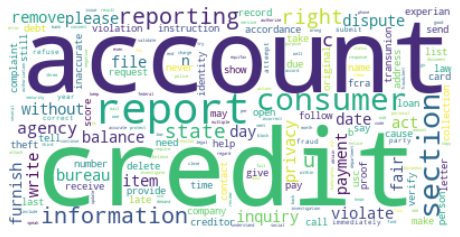

Word Cloud for Product : Debt collection


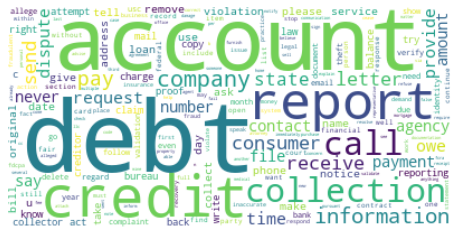

Word Cloud for Product : Credit card or prepaid card


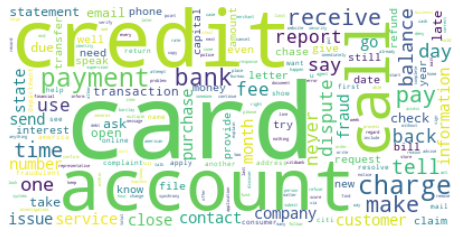

Word Cloud for Product : Checking or savings account


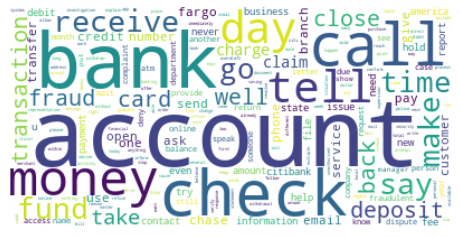

Word Cloud for Product : Mortgage


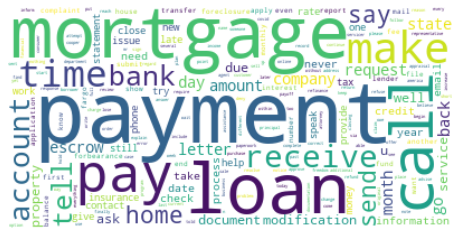

Word Cloud for Product : Money transfer, virtual currency, or money service


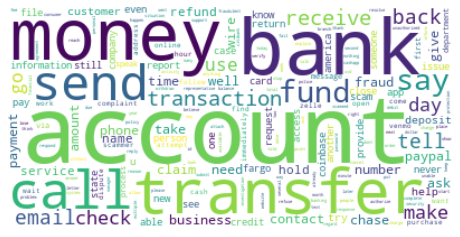

Word Cloud for Product : Student loan


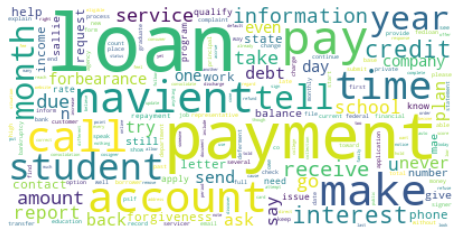

Word Cloud for Product : Vehicle loan or lease


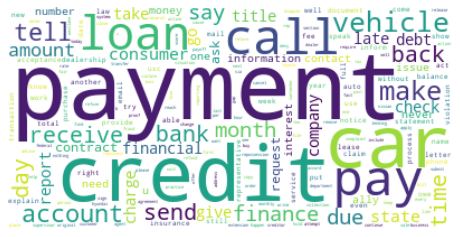

Word Cloud for Product : Payday loan, title loan, or personal loan


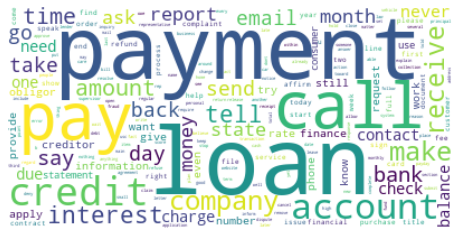

Word Cloud for Product : Credit reporting


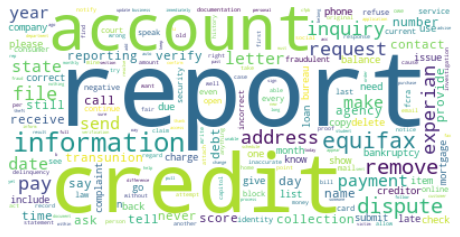

Word Cloud for Product : Credit card


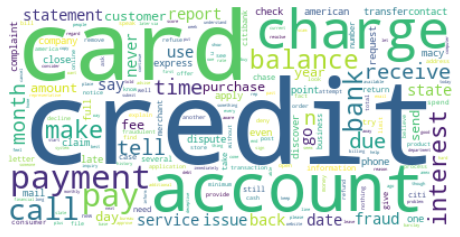

Word Cloud for Product : Bank account or service


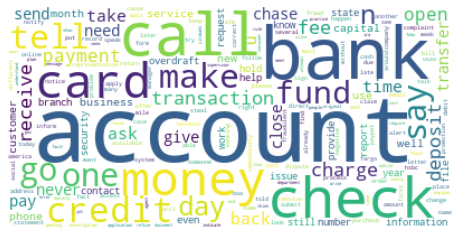

Word Cloud for Product : Consumer Loan


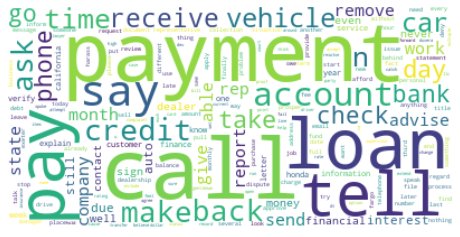

Word Cloud for Product : Payday loan


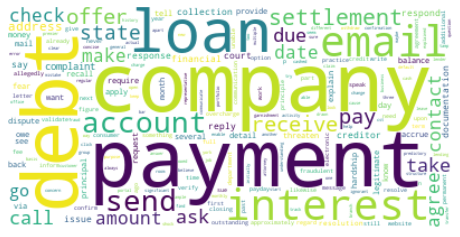

Word Cloud for Product : Money transfers


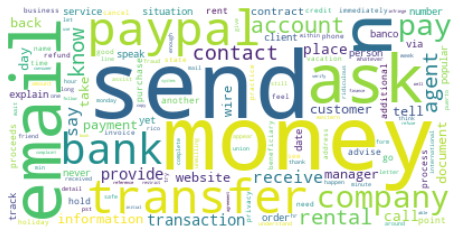

Word Cloud for Product : Prepaid card


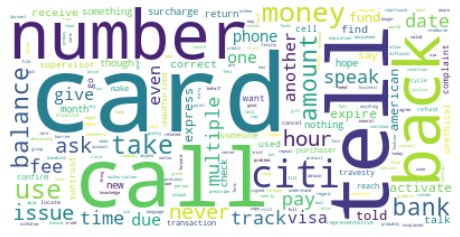

Word Cloud for Product : Other financial service


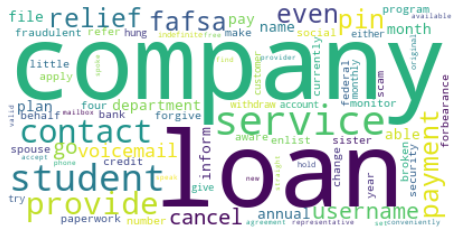

In [24]:
#Word Cloud Creation to see words with higestest frequency for each product

for productname in df_product['product_name']:
    fig = plt.figure(figsize=(8,6))
    print("Word Cloud for Product :",productname)
    
    text = " ".join(cat for cat in df_train[df_train['product']==productname].clean_text )

    # Creating word_cloud with text as argument in .generate() method
    word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)
    # Display the generated Word Cloud
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

### Word2Vec Model

In [25]:
# create Word2vec model
#here words_f should be a list containing words from each document. say 1st row of the list is words from the 1st document/sentence
#length of words_f is number of documents/sentences in your dataset
df_train['clean_text_tokens']=[nltk.word_tokenize(i) for i in df_train['clean_text']] #convert preprocessed sentence to tokenized sentence
model = Word2Vec(df_train['clean_text_tokens'],min_count=1)  #min_count=1 means word should be present at least across all documents,
#if min_count=2 means if the word is present less than 2 times across all the documents then we shouldn't consider it


w2v = dict(zip(model.wv.index_to_key, model.wv.vectors))  #combination of word and its vector
print(w2v)

#for converting sentence to vectors/numbers from word vectors result by Word2Vec
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [26]:
#model.wv.key_to_index

In [27]:
df_train

,product,complaint_narrative,clean_text,clean_text_tokens
36,"Credit reporting, credit repair services, or o...",This is the second time I am filing a dispute ...,second time file dispute fair collection outso...,"[second, time, file, dispute, fair, collection..."
147,"Credit reporting, credit repair services, or o...","XX/XX/XXXX, & XXXX, XX/XX/XXXX, and XXXX lette...",letter send dispute remove invalid information,"[letter, send, dispute, remove, invalid, infor..."
155,"Credit reporting, credit repair services, or o...",This is my NUMEROUS request that I have been a...,numerous request victim identity theft one see...,"[numerous, request, victim, identity, theft, o..."
258,"Credit reporting, credit repair services, or o...",in accordance with the Fair Credit Reporting a...,accordance fair credit reporting act account n...,"[accordance, fair, credit, reporting, act, acc..."
324,"Credit reporting, credit repair services, or o...",Hi I am submitting this XXXX XXXX this isn't a...,hi submit influence third party low unfair cre...,"[hi, submit, influence, third, party, low, unf..."
...,...,...,...,...
57162,"Credit reporting, credit repair services, or o...",I XXXX XXXX am filing this complaint on behalf...,file complaint behalf false reporting mislead ...,"[file, complaint, behalf, false, reporting, mi..."
57163,Debt collection,A Debt validation letter was sent to H & R Acc...,debt validation letter send h r account give d...,"[debt, validation, letter, send, h, r, account..."
57168,Debt collection,on XX/XX/2021 i called Discover Bank in order ...,call discover bank order let know fraudulent a...,"[call, discover, bank, order, let, know, fraud..."
57170,"Credit reporting, credit repair services, or o...",Current employer : XXXX XXXX XXXX XXXX deleted...,current employer delete incorrect information ...,"[current, employer, delete, incorrect, informa..."


### TRAIN TEST SPLITTING OF LABELLED DATASET

In [28]:
#SPLITTING THE TRAINING DATASET INTO TRAINING AND VALIDATION
X_train, X_val, y_train, y_val = train_test_split(df_train["clean_text"],
                                                  df_train["product"],
                                                  test_size=0.2,
                                                  shuffle=True)

X_train_tokens= [nltk.word_tokenize(i) for i in X_train]  #for word2vec
X_val_tokens= [nltk.word_tokenize(i) for i in X_val]      #for word2vec



### TF-IDF

In [29]:
# Convert x_train to vector since model can only run on numbers and not words- Fit and transform
tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) #tfidf runs on non-tokenized sentences unlike word2vec

# Only transform x_test (not fit and transform)
X_val_vectors_tfidf = tfidf_vectorizer.transform(X_val) #Don't fit() your TfidfVectorizer to your test data: it will 
#change the word-indexes & weights to match test data. Rather, fit on the training data, then use the same train-data-
#fit model on the test data, to reflect the fact you're analyzing the test data only based on what was learned without 
#it, and the have compatible


#Word2vec
# Fit and transform
modelw              = MeanEmbeddingVectorizer(w2v)
X_train_vectors_w2v = modelw.transform(X_train_tokens)
X_val_vectors_w2v   = modelw.transform(X_val_tokens)

In [30]:
y_train_tokens= [nltk.word_tokenize(i) for i in y_train]  #for word2vec


In [31]:
y_train_vectors_w2v = modelw.transform(y_train_tokens)

In [32]:
 len(X_train)#, y_val

12802

### Building ML models (Text-classification)
### Logistic Regression (tf-idf)

In [33]:
import warnings
warnings.filterwarnings('ignore')

#FITTING THE CLASSIFICATION MODEL using Logistic Regression(tf-idf)

lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf.fit(X_train_vectors_tfidf, y_train)  #model

#Predict y value for test dataset
y_predict = lr_tfidf.predict(X_val_vectors_tfidf)
y_prob    = lr_tfidf.predict_proba(X_val_vectors_tfidf)[:,1]
 

print(classification_report(y_val,y_predict))
print('Confusion Matrix:',confusion_matrix(y_val, y_predict))
 
# fpr, tpr, thresholds = roc_curve(y_val, y_prob)
# roc_auc = auc(fpr, tpr)
# print('AUC:', roc_auc)  

                                                                              precision    recall  f1-score   support

                                                     Bank account or service       0.00      0.00      0.00        24
                                                 Checking or savings account       0.70      0.83      0.76       198
                                                               Consumer Loan       0.00      0.00      0.00         3
                                                                 Credit card       0.00      0.00      0.00        20
                                                 Credit card or prepaid card       0.67      0.75      0.70       201
                                                            Credit reporting       0.00      0.00      0.00        19
Credit reporting, credit repair services, or other personal consumer reports       0.91      0.95      0.93      2002
                                                       

### Naive Bayes (tf-idf)

In [34]:
#FITTING THE CLASSIFICATION MODEL using Naive Bayes(tf-idf)
#It's a probabilistic classifier that makes use of Bayes' Theorem, a rule that uses probability to make predictions based on prior knowledge of conditions that might be related. This algorithm is the most suitable for such large dataset as it considers each feature independently, calculates the probability of each category, and then predicts the category with the highest probability.

nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_vectors_tfidf, y_train)  #model

#Predict y value for test dataset
y_predict = nb_tfidf.predict(X_val_vectors_tfidf)
y_prob    = nb_tfidf.predict_proba(X_val_vectors_tfidf)[:,1]
 

print(classification_report(y_val,y_predict))
print('Confusion Matrix:',confusion_matrix(y_val, y_predict))
 
# fpr, tpr, thresholds = roc_curve(y_val, y_prob)
# roc_auc = auc(fpr, tpr)
# print('AUC:', roc_auc)  

                                                                              precision    recall  f1-score   support

                                                     Bank account or service       0.00      0.00      0.00        24
                                                 Checking or savings account       0.64      0.72      0.67       198
                                                               Consumer Loan       0.00      0.00      0.00         3
                                                                 Credit card       0.00      0.00      0.00        20
                                                 Credit card or prepaid card       0.53      0.67      0.59       201
                                                            Credit reporting       0.00      0.00      0.00        19
Credit reporting, credit repair services, or other personal consumer reports       0.85      0.98      0.91      2002
                                                       

### Test Naive Bayes using TF-IDF

In [35]:
df_test_naive=pd.read_csv('complaints_test.csv') 
df_test_naive['clean_text'] = df_test_naive['complaint_narrative'].apply(lambda x: preprocess(x))
X_test_naive=df_test_naive['clean_text'] 
y_train_vectors_tfidf = tfidf_vectorizer.transform(X_test_naive)


In [36]:
y_predict_naive = nb_tfidf.predict(y_train_vectors_tfidf)
y_prob_naive    = nb_tfidf.predict_proba(y_train_vectors_tfidf)[:,1]
df_test_naive['predict_prob']= y_prob_naive
df_test_naive['target_product']= y_predict_naive

In [37]:
df_test_naive

,Product,issue,Sub-issue,complaint_narrative,clean_text,predict_prob,target_product
0,Checking or savings account,Managing an account,Problem using a debit or ATM card,I received a phone call from US Bank Fraud Dep...,receive phone call u bank fraud department aro...,0.734591,Checking or savings account
1,Debt collection,Attempts to collect debt not owed,Debt was result of identity theft,I moved into an apartment in XXXX XXXX XXXX XX...,move apartment call month move go home week fa...,0.089503,"Credit reporting, credit repair services, or o..."


### Performance Metrics for Naive Bayes using TF-IDF

In [38]:
df_test_naive=pd.DataFrame(y_val)
df_test_naive['predicted']=y_predict

In [39]:
df_test_naive

,product,predicted
24227,Debt collection,"Credit reporting, credit repair services, or o..."
51413,"Credit reporting, credit repair services, or o...","Credit reporting, credit repair services, or o..."
1730,"Payday loan, title loan, or personal loan","Credit reporting, credit repair services, or o..."
53412,Debt collection,Debt collection
41537,"Credit reporting, credit repair services, or o...","Credit reporting, credit repair services, or o..."
...,...,...
22900,Mortgage,Mortgage
24436,"Credit reporting, credit repair services, or o...","Credit reporting, credit repair services, or o..."
16855,Mortgage,Mortgage
33234,"Credit reporting, credit repair services, or o...","Credit reporting, credit repair services, or o..."


In [40]:
cf_matrix_naive=confusion_matrix(df_test_naive['product'],df_test_naive['predicted'])
print(cf_matrix_naive)

[[   0   13    0    0   10    0    1    0    0    0    0    0    0    0
     0    0]
 [   0  142    0    0   32    0   22    2    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    3    0    0    0
     0    0]
 [   0    0    0    0   15    0    5    0    0    0    0    0    0    0
     0    0]
 [   0    8    0    0  134    0   56    3    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0   17    2    0    0    0    0    0    0
     0    0]
 [   0    2    0    0   16    0 1954   23    0    0    7    0    0    0
     0    0]
 [   0    2    0    0    4    0  170  152    0    0    7    0    0    0
     0    0]
 [   0   48    0    0   18    0   13    1    3    0    2    0    0    0
     0    0]
 [   0    1    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    4    0    0    6    0   19    6    0    0  168    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    1    0    0    0    0    

In [41]:
accuracy=accuracy_score(df_test_naive['product'],df_test_naive['predicted'])*100
print('Accuracy of the model is {} %'.format(round(accuracy,2)))

print('Precision score is {} %'.format(precision_score(df_test_naive['product'], df_test_naive['predicted'],average='micro')*100))
print('Recall score is {} %'.format(recall_score(df_test_naive['product'], df_test_naive['predicted'],average='micro')*100))
print('F1 score is {} %'.format(round(f1_score(df_test_naive['product'], df_test_naive['predicted'],average='micro')*100,2)))

Accuracy of the model is 79.79 %
Precision score is 79.78756638550453 %
Recall score is 79.78756638550453 %
F1 score is 79.79 %


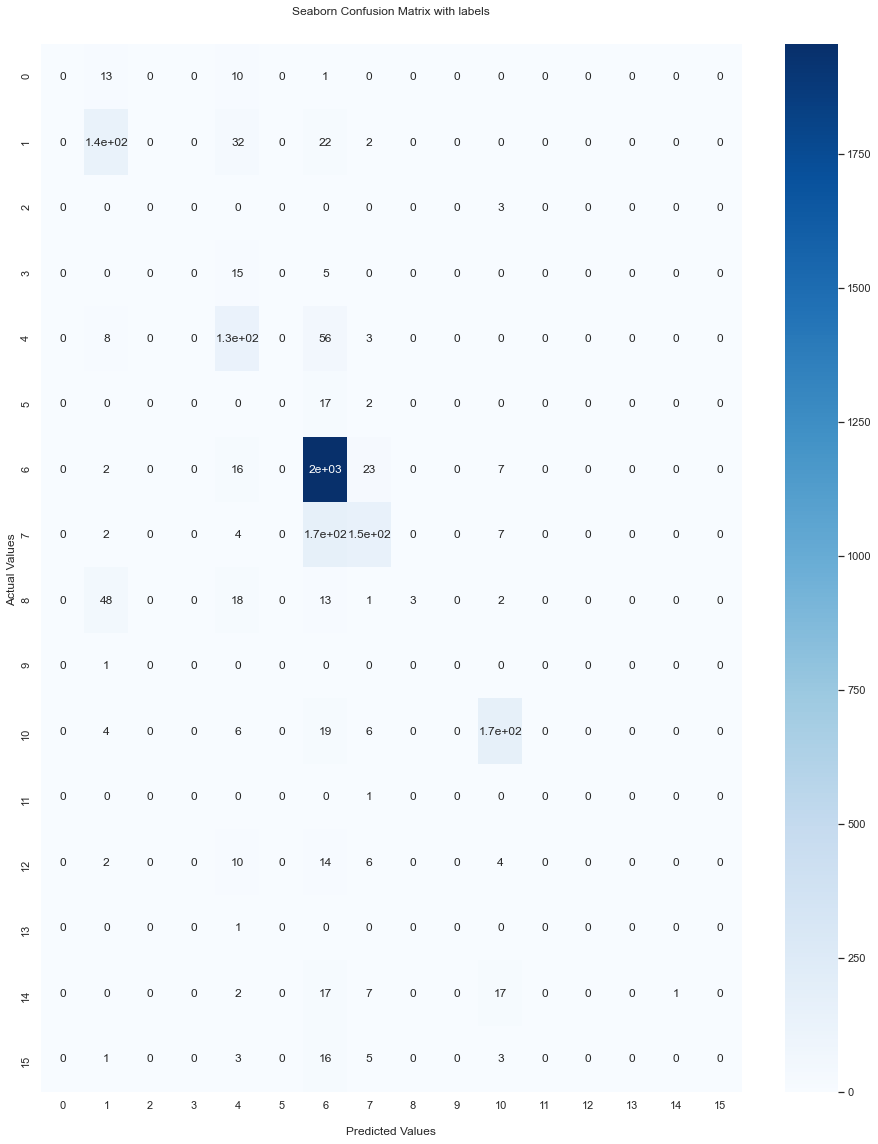

In [42]:
ax = sns.heatmap(cf_matrix_naive, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Display the visualization of the Confusion Matrix.
plt.show()

### Logistic Regression (w2v)

In [43]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression (W2v)
lr_w2v=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_w2v.fit(X_train_vectors_w2v, y_train)  #model

#Predict y value for test dataset
y_predict = lr_w2v.predict(X_val_vectors_w2v)

y_prob = lr_w2v.predict_proba(X_val_vectors_w2v)[:,1]
 

print(classification_report(y_val,y_predict))
print('Confusion Matrix:',confusion_matrix(y_val, y_predict))
 


                                                                              precision    recall  f1-score   support

                                                     Bank account or service       0.00      0.00      0.00        24
                                                 Checking or savings account       0.62      0.71      0.66       198
                                                               Consumer Loan       0.00      0.00      0.00         3
                                                                 Credit card       0.00      0.00      0.00        20
                                                 Credit card or prepaid card       0.61      0.65      0.63       201
                                                            Credit reporting       0.00      0.00      0.00        19
Credit reporting, credit repair services, or other personal consumer reports       0.89      0.95      0.92      2002
                                                       

In [44]:
print(y_predict)

['Credit reporting, credit repair services, or other personal consumer reports'
 'Credit reporting, credit repair services, or other personal consumer reports'
 'Credit reporting, credit repair services, or other personal consumer reports'
 ... 'Mortgage'
 'Credit reporting, credit repair services, or other personal consumer reports'
 'Checking or savings account']


### Testing Using Logistic Regression & WordToVec Model

In [45]:
df_test=pd.read_csv('complaints_test.csv') 
df_test['clean_text'] = df_test['complaint_narrative'].apply(lambda x: preprocess(x))

In [46]:
X_test=df_test['clean_text'] 
X_test_tokens= [nltk.word_tokenize(i) for i in X_test]  #for word2vec
y_train_vectors_w2v = modelw.transform(X_test_tokens)
y_predict = lr_w2v.predict(y_train_vectors_w2v)
y_prob = lr_w2v.predict_proba(y_train_vectors_w2v)[:,1]
df_test['predict_prob']= y_prob
df_test['target_product']= y_predict

In [47]:
df_test

,Product,issue,Sub-issue,complaint_narrative,clean_text,predict_prob,target_product
0,Checking or savings account,Managing an account,Problem using a debit or ATM card,I received a phone call from US Bank Fraud Dep...,receive phone call u bank fraud department aro...,0.670492,Checking or savings account
1,Debt collection,Attempts to collect debt not owed,Debt was result of identity theft,I moved into an apartment in XXXX XXXX XXXX XX...,move apartment call month move go home week fa...,0.188288,Debt collection


### Logistic Regression & WordToVec Model Performance Matrix

In [48]:
predict_y=lr_w2v.predict(X_val_vectors_w2v)

In [49]:
df_test=pd.DataFrame(y_val)

In [50]:
df_test.head()

,product
24227,Debt collection
51413,"Credit reporting, credit repair services, or o..."
1730,"Payday loan, title loan, or personal loan"
53412,Debt collection
41537,"Credit reporting, credit repair services, or o..."


In [51]:
df_test['predicted']=predict_y

In [52]:
df_test.head()

,product,predicted
24227,Debt collection,"Credit reporting, credit repair services, or o..."
51413,"Credit reporting, credit repair services, or o...","Credit reporting, credit repair services, or o..."
1730,"Payday loan, title loan, or personal loan","Credit reporting, credit repair services, or o..."
53412,Debt collection,Debt collection
41537,"Credit reporting, credit repair services, or o...","Credit reporting, credit repair services, or o..."


In [53]:
cf_matrix=confusion_matrix(df_test['product'],df_test['predicted'])

In [54]:
accuracy=accuracy_score(df_test['product'],df_test['predicted'])*100
print('Accuracy of the model is {} %'.format(round(accuracy,2)))

print('Precision score is {} %'.format(precision_score(df_test['product'], df_test['predicted'],average='micro')*100))
print('Recall score is {} %'.format(recall_score(df_test['product'], df_test['predicted'],average='micro')*100))
print('F1 score is {} %'.format(round(f1_score(df_test['product'], df_test['predicted'],average='micro')*100,2)))


Accuracy of the model is 81.94 %
Precision score is 81.94314276788504 %
Recall score is 81.94314276788504 %
F1 score is 81.94 %


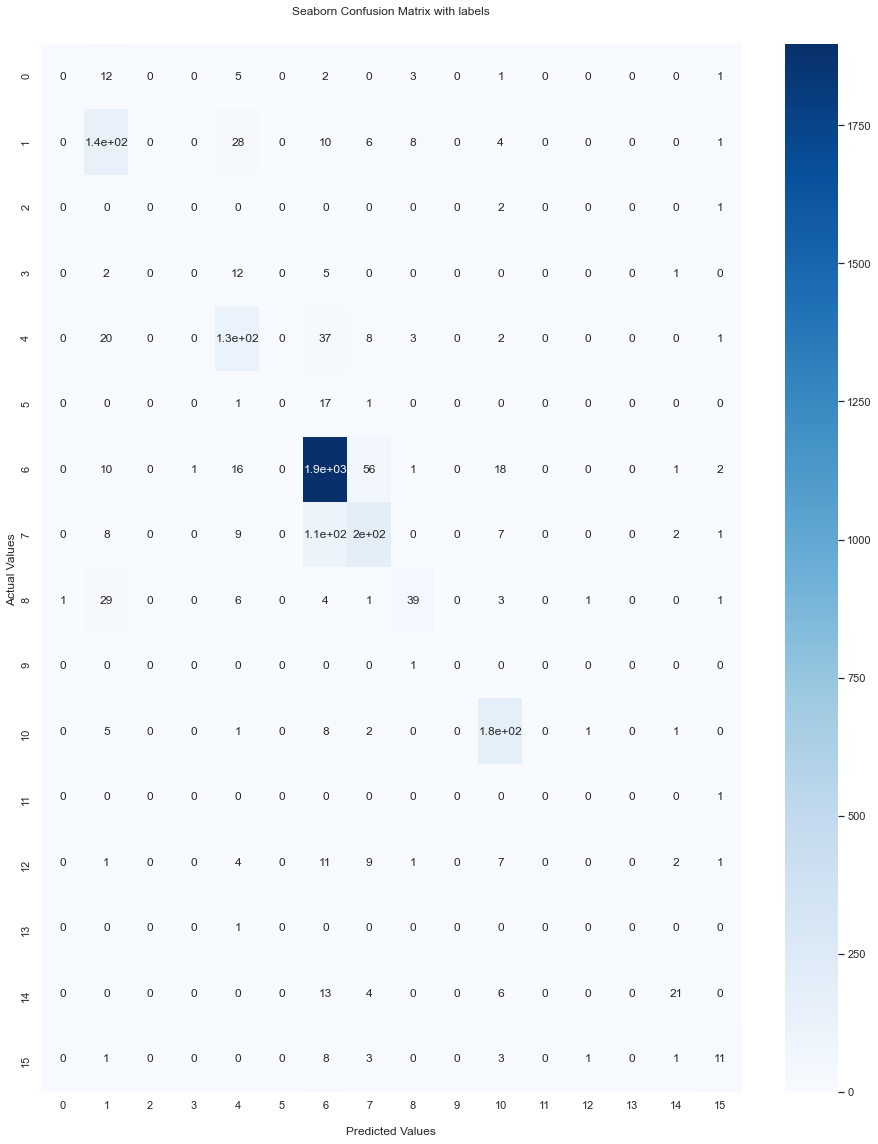

In [55]:
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Display the visualization of the Confusion Matrix.
plt.show()

### Testing Using Logistic Regression & TFIDF Model

In [56]:
#Testing it on new dataset with the best model
df_test=pd.read_csv('complaints_test.csv')  #reading the data
df_test['clean_text'] = df_test['complaint_narrative'].apply(lambda x: preprocess(x)) #preprocess the data

#df_train['clean_text'] = df_train['complaint_narrative'].apply(lambda x: finalpreprocess(x))

X_test=df_test['clean_text'] 
X_vector=tfidf_vectorizer.transform(X_test) #converting X_test to vector
y_predict = lr_tfidf.predict(X_vector)      #use the trained model on X_vector
y_prob = lr_tfidf.predict_proba(X_vector)[:,1]
df_test['predict_prob']= y_prob
df_test['target_product']= y_predict

df_test=pd.DataFrame(df_test)

In [57]:
df_test

,Product,issue,Sub-issue,complaint_narrative,clean_text,predict_prob,target_product
0,Checking or savings account,Managing an account,Problem using a debit or ATM card,I received a phone call from US Bank Fraud Dep...,receive phone call u bank fraud department aro...,0.536152,Checking or savings account
1,Debt collection,Attempts to collect debt not owed,Debt was result of identity theft,I moved into an apartment in XXXX XXXX XXXX XX...,move apartment call month move go home week fa...,0.081434,Debt collection


### Logistic Regression & TFIDF Model Performance Matrix

In [58]:
predict_y=lr_tfidf.predict(X_val_vectors_tfidf)

In [59]:
df_test=pd.DataFrame(y_val)

In [60]:
df_test['predicted']=predict_y

In [61]:
cf_matrix=confusion_matrix(df_test['product'],df_test['predicted'])
print(cf_matrix)

[[   0   19    0    0    2    0    1    0    1    0    0    0    0    0
     0    1]
 [   0  165    0    0   19    0    7    4    2    0    0    0    0    0
     0    1]
 [   0    0    0    0    0    0    0    0    0    0    2    0    0    0
     0    1]
 [   0    0    0    0   16    0    4    0    0    0    0    0    0    0
     0    0]
 [   0   14    0    0  150    0   24    7    3    0    1    0    0    0
     0    2]
 [   0    0    0    0    0    0   16    3    0    0    0    0    0    0
     0    0]
 [   0    7    0    0   17    0 1906   51    2    0   10    0    1    0
     1    7]
 [   0    2    0    0    8    0   88  226    0    0    5    0    0    0
     3    3]
 [   0   22    0    0    6    0    5    2   48    0    2    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    1    0    0    0    0    0
     0    0]
 [   0    3    0    0    2    0    9    1    0    0  188    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    1    0    0    0    0    

In [62]:
accuracy=accuracy_score(df_test['product'],df_test['predicted'])*100
print('Accuracy of the model is {} %'.format(round(accuracy,2)))

print('Precision score is {} %'.format(precision_score(df_test['product'], df_test['predicted'],average='micro')*100))
print('Recall score is {} %'.format(recall_score(df_test['product'], df_test['predicted'],average='micro')*100))
print('F1 score is {} %'.format(round(f1_score(df_test['product'], df_test['predicted'],average='micro')*100,2)))

Accuracy of the model is 85.41 %
Precision score is 85.41080912214933 %
Recall score is 85.41080912214933 %
F1 score is 85.41 %


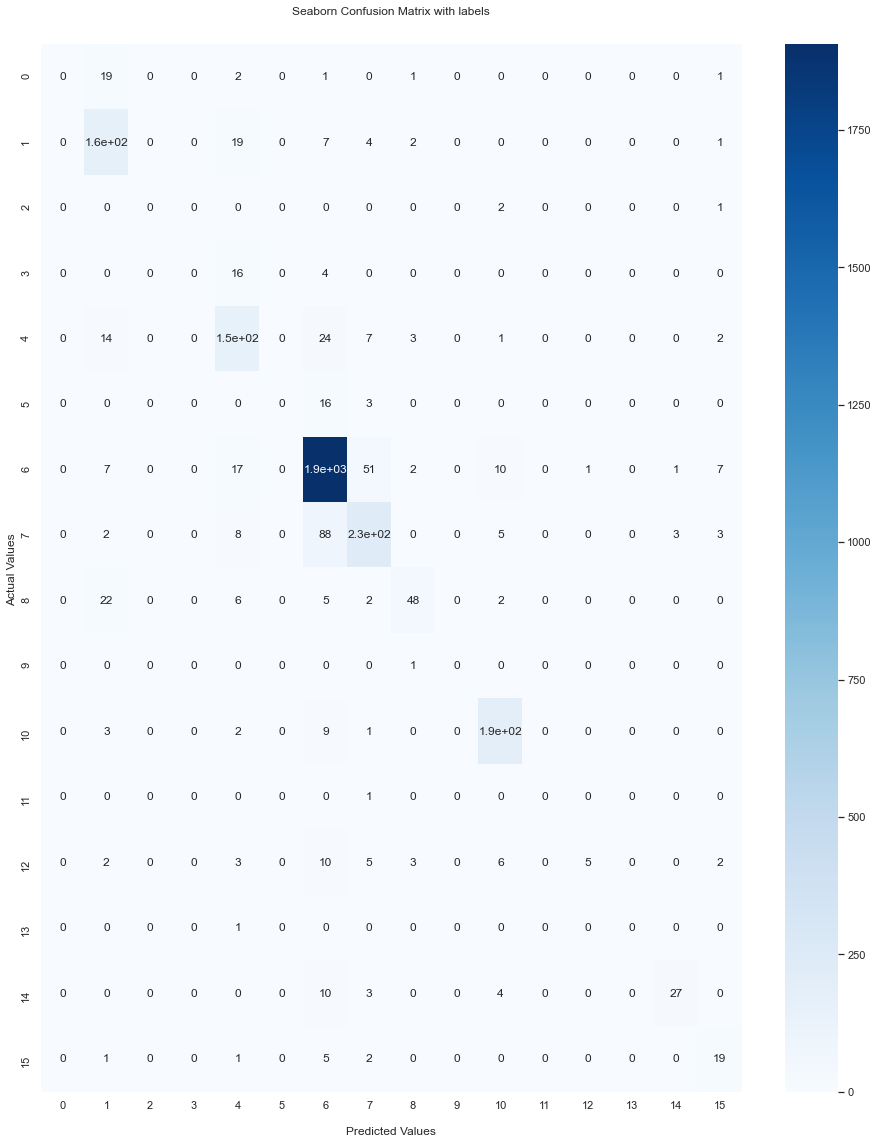

In [63]:
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Display the visualization of the Confusion Matrix.
plt.show()